In [3]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statistics as stat
import math
import scipy.stats as st

In [4]:
N=200
N1 = sum(np.random.randint(0,2,size = N) == 0)
N2 = N-N1

mean1 = np.array([2.5,2.5])
cov1 = np.array([[2,-0.8],[-0.8,2]])
X1 = np.random.multivariate_normal(mean1, cov1, N1)
label1 = 1

mean2 = np.array([0,0])
cov2 = np.array([[1,0],[0,1]])
X2 = np.random.multivariate_normal(mean2, cov2, N2)
label2 = 0

x1,x2 = [],[]
for i in range(N1):
    x1 += [list(X1[i,]) + [label1]]
for i in range(N2):
    x2 += [list(X2[i,]) + [label2]]
X = np.array(x1+x2)



### Grid of size  15*15

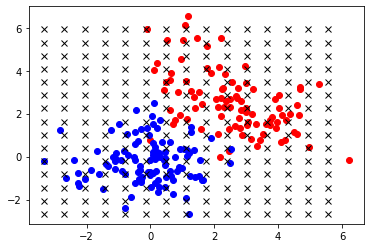

In [5]:
x1_min, x1_max=min(X[:,0]), max(X[:,0])
x2_min, x2_max=min(X[:,1]), max(X[:,1])
Neval=15;h1=(x1_max-x1_min)/Neval;h2=(x2_max-x2_min)/Neval
x1Eval, x2Eval=np.meshgrid(np.arange(x1_min, x1_max, h1), np.arange(x2_min, x2_max, h2));
plt.plot(X1[:,0],X1[:,1],'ro')
plt.plot(X2[:,0],X2[:,1],'bo')
plt.plot(x1Eval,x2Eval,'kx')
plt.show()

### Random Forest

#### Model Calibration on train set

In [6]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
#tree = tree.DecisionTreeClassifier()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)

RF = RandomForestClassifier(max_depth=2, random_state=0, oob_score = True)
RFfit = RF.fit(X_train, y_train);

In [7]:
score=RF.score;
OOB=RF.oob_score_
IF=RF.feature_importances_

In [8]:
perf = {'train_accuracy' : score(X_train,y_train),
       'test_accuracy' : score(X_test, y_test), 
       'OOB_score' : OOB,
       'Features_importance' : IF}
perf

{'train_accuracy': 0.9849624060150376,
 'test_accuracy': 0.9402985074626866,
 'OOB_score': 0.9473684210526315,
 'Features_importance': array([0.46209614, 0.53790386])}

#### map

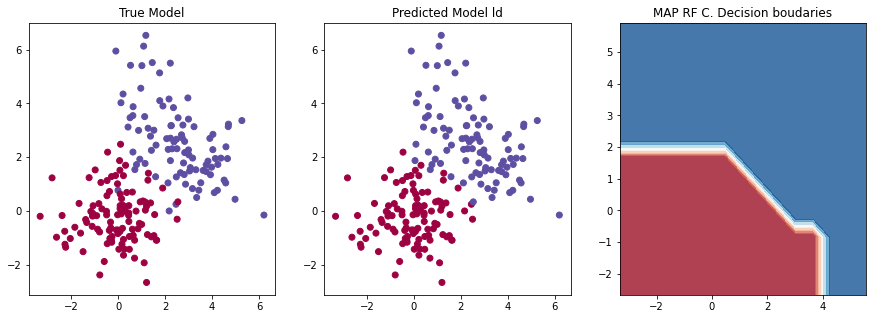

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = RFfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP RF C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = RFfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

### ADABOOST

##### Overall data

In [10]:
##Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
Ab = AdaBoostClassifier(n_estimators=100, random_state=0)
Abfit=Ab.fit(X[:,0:2], X[:,2])
y_pred=Abfit.predict(X[:,0:2]);
E_all=(X[:,2] != y_pred).sum()/len(X[:,2])
print("Boost Error on the complete training set %5.2f->",E_all)

Boost Error on the complete training set %5.2f-> 0.0


##### Separating train and test

In [11]:
#### splitting data
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)
#### Training data
Ab = AdaBoostClassifier(n_estimators=100, random_state=0)
Abfit=Ab.fit(X_train, y_train)
y_pred_train=Abfit.predict(X_train);
E_train=(y_train != y_pred_train).sum()/len(y_train)
print("Boost Error on the complete training set %5.2f->",E_train)

#### prediction on test data
y_pred_test=Abfit.predict(X_test);
E_test=(y_test != y_pred_test).sum()/len(y_test)
print("Boost Error on the complete training set %5.2f->",E_test)

Boost Error on the complete training set %5.2f-> 0.0
Boost Error on the complete training set %5.2f-> 0.04477611940298507


#### map ADABOOST

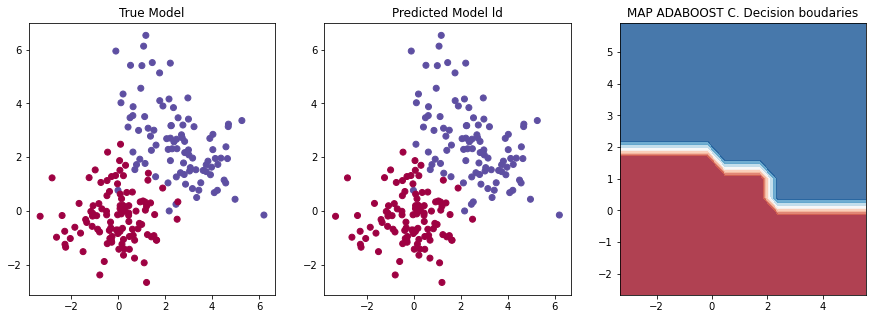

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = Abfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP ADABOOST C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = Abfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

#### Structure of the successive Adaboost trees

In [13]:
import matplotlib.pyplot as plt
Ad = AdaBoostClassifier(n_estimators=200, random_state=0)
Ad.fit(X[:,0:2], X[:,2])

AdaBoostClassifier(n_estimators=200, random_state=0)

Text(0.5, 0, 'Number of Trees')

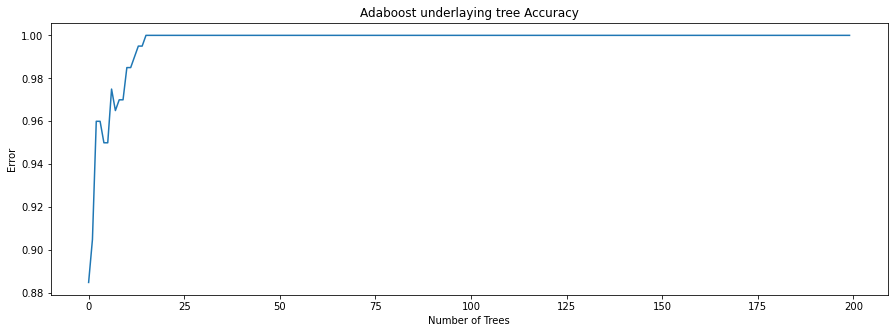

In [14]:
Ad_seq_errors = []
for Ad_train_predict in Ad.staged_predict(X[:,0:2]):
    Ad_seq_errors.append(metrics.accuracy_score(Ad_train_predict, X[:,2]))
plt.figure(figsize=(15, 5))
plt.plot(Ad_seq_errors); plt.title('Adaboost underlaying tree Accuracy')
plt.ylabel('Error'); plt.xlabel('Number of Trees')

### Gradient Boosting

#### Model calibration

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state=0)
GBfit=GB.fit(X[:,0:2], X[:,2])
y_pred=GBfit.predict(X[:,0:2])
E_all=(X[:,2] != y_pred).sum()/len(X[:,2])
print("Gradient Boosting Error on the complete training set %5.2f->",E_all)

Gradient Boosting Error on the complete training set %5.2f-> 0.0


In [16]:
#### splitting data
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)
#### Training data
GB = GradientBoostingClassifier(random_state=0)
GBfit=GB.fit(X_train, y_train)
y_pred_train=GBfit.predict(X_train);
E_train=(y_train != y_pred_train).sum()/len(y_train)
print("Boost Error on the complete training set %5.2f->",E_train)

#### prediction on test data
y_pred_test=GBfit.predict(X_test);
E_test=(y_test != y_pred_test).sum()/len(y_test)
print("Boost Error on the complete training set %5.2f->",E_test)

Boost Error on the complete training set %5.2f-> 0.0
Boost Error on the complete training set %5.2f-> 0.04477611940298507


#### map Gradient Boosting

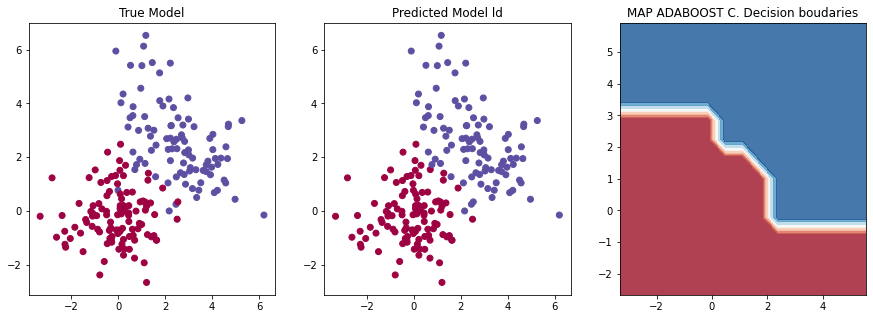

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = GBfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP ADABOOST C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = GBfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

#### Structure of the successive Adaboost trees

In [18]:
import matplotlib.pyplot as plt
GB = GradientBoostingClassifier(random_state=0)
GB.fit(X[:,0:2], X[:,2])

GradientBoostingClassifier(random_state=0)

Text(0.5, 0, 'Number of Trees')

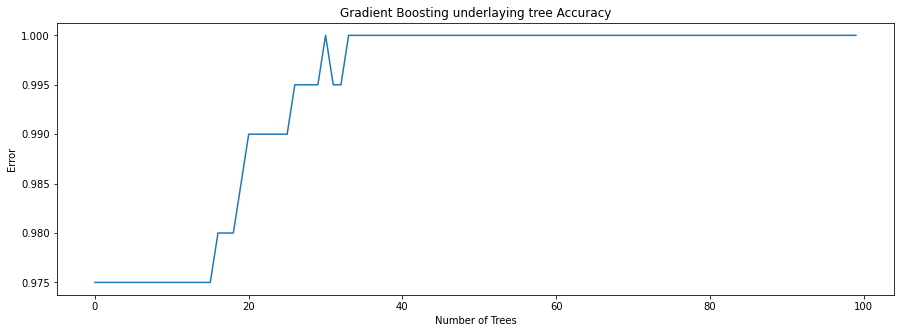

In [19]:
GB_seq_errors = []
for GB_train_predict in GB.staged_predict(X[:,0:2]):
    GB_seq_errors.append(metrics.accuracy_score(GB_train_predict, X[:,2]))

plt.figure(figsize=(15, 5))
plt.plot(GB_seq_errors); plt.title('Gradient Boosting underlaying tree Accuracy')
plt.ylabel('Error'); plt.xlabel('Number of Trees')

#### Stacking

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# get a stacking ensemble of models
def stack_model():
    # define the base models
    level0 = list()
    level0.append(('bayes', GaussianNB()))
    level0.append(('lda', LinearDiscriminantAnalysis(n_components=1)))
    level0.append(('qda', QuadraticDiscriminantAnalysis()))
    level0.append(('knn', KNeighborsClassifier(n_neighbors=5)))
    level0.append(('logreg', LogisticRegression(C=1e5)))
    level0.append(('Tree', DecisionTreeClassifier()))

    # define meta learner model
    level1 = DecisionTreeClassifier(random_state=0)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [21]:
stack = stack_model()
stackfit = stack.fit(X[:,0:2], X[:,2])
y_pred=stackfit.predict(X[:,0:2]);
E_all=(X[:,2] != y_pred).sum()/len(X[:,2])
print("Stack Error on the complete training set %5.2f->",E_all)

Stack Error on the complete training set %5.2f-> 0.055


In [22]:
#### splitting data
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)
#### Training data
stack = stack_model()
stackfit=stack.fit(X_train, y_train)
y_pred_train=stackfit.predict(X_train);
E_train=(y_train != y_pred_train).sum()/len(y_train)
print("Stack Error on the complete training set %5.2f->",E_train)

#### prediction on test data
y_pred_test=stackfit.predict(X_test);
E_test=(y_test != y_pred_test).sum()/len(y_test)
print("Stack Error on the complete test set %5.2f->",E_test)

Stack Error on the complete training set %5.2f-> 0.007518796992481203
Stack Error on the complete test set %5.2f-> 0.07462686567164178


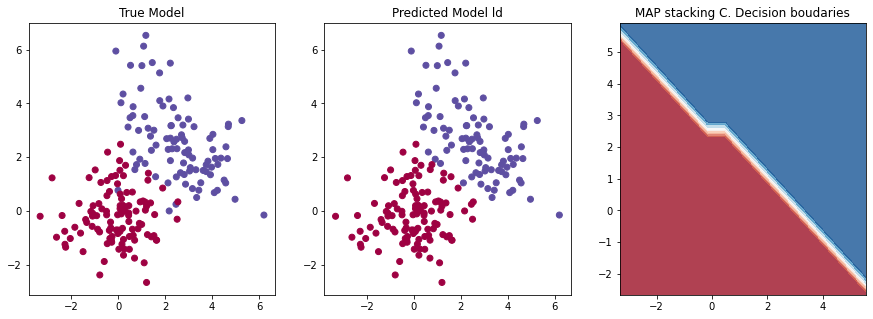

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = stackfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP stacking C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = stackfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

#### Classification models for a real application: the Heart dataset.

In [121]:
#Application SA Heart####################################
import pandas as pd
import numpy as np
tab=pd.read_csv('SAheart.txt')
#print(tab)
np.shape(tab)## (462, 11)
Y=tab["chd"]
Xnum=tab.loc[:,['famhist','sbp','tobacco','ldl','adiposity','typea','obesity','alcohol','age']]
Xnum['famhist'] = (Xnum['famhist'] == 'Present')*1.0
X=Xnum#.to_numpy();

In [122]:
X.shape

(462, 9)

In [123]:
# get a stacking ensemble of models
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

params = {'tree' : {'max_depth': [None,1,3, 5, 7],
              'min_samples_split': [2, 5, 10]},
         'RF' : {'n_estimators' : [int(x) for x in np.linspace(10,200, num = 25) ],
                'max_features' : ['auto', 'sqrt'],
                 'max_depth' : [None,1,3, 5, 7], 
                'bootstrap' : [False,True]}, # [int(x) for x in np.linspace(10, 110, num = 11)],
                #'oob_score' : [F]},
          'Adaboost' : {'n_estimators' : [int(x) for x in np.linspace(10,200, num = 30)],
                       'learning_rate' : [0.001,0.01,0.1,0.2,0.5]},
                       #'max_depth' : [3, 5, 7,9, None]},
          'GB' : {'learning_rate' : [0.5, 0.25, 0.1, 0.05, 0.01, 0.001],
                 'n_estimators' : [int(x) for x in np.linspace(10,200, num = 30) ],
                 'max_depth' : [3, 5, 7,None,9]}
         }

def stack_model():
    # define the base models
    level0 = list()
    level0.append(('bayes', GaussianNB()))
    level0.append(('lda', LinearDiscriminantAnalysis(n_components=1)))
    level0.append(('qda', QuadraticDiscriminantAnalysis()))
    level0.append(('knn', KNeighborsClassifier(n_neighbors=5)))
    #level0.append(('logreg', make_pipeline(StandardScaler(), LogisticRegression(C = 1e5))))
    level0.append(('Tree', DecisionTreeClassifier()))

    # define meta learner model
    level1 = DecisionTreeClassifier(random_state=0)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['tree'] = DecisionTreeClassifier()
    models['RF'] = RandomForestClassifier()
    models['Adaboost'] = AdaBoostClassifier()
    models['GB'] = GradientBoostingClassifier()
    #models['Stacking'] = stack_model()
    
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

def scoring_function(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true=y_true,y_pred=y_pred)
    precision = metrics.precision_score(y_true=y_true, y_pred=y_pred)
    f1_score = metrics.f1_score(y_true=y_true,y_pred=y_pred)
    recall = metrics.recall_score(y_true=y_true,y_pred=y_pred)
    perf = {'accuracy' : accuracy,'precision' : precision,
           'f1_score' : f1_score, 'recall' : recall}
    return perf

In [137]:
ff = {}
ff['fdg'] = 2
ff['sff'] = 3
ff

models.items()

dict_items([('tree', DecisionTreeClassifier()), ('RF', RandomForestClassifier()), ('Adaboost', AdaBoostClassifier()), ('GB', GradientBoostingClassifier())])

In [130]:
#### splitting data
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import time 

models = get_models()
stackModel = stack_model()
perf = {}
model_trained = {}
X_train, X_test, y_train, y_test =  train_test_split(X, 
                                                     Y, 
                                                     test_size=1/4)

scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision','f1_score' : 'f1', 'recall' : 'recall'}
i = 1
for name, model in models.items():
    print("-----------------tunning hyperparameters model {} : {}----------------".format(i, name))
    i+=1
    start = time.time()
    model_i = GridSearchCV(model,
                  param_grid=params[name],cv = 3,
                  scoring="accuracy", refit='accuracy', verbose=2, n_jobs=4 ,return_train_score=True).fit(X_train, y_train)
    
    print('Execution time {}   : {} seconds'.format(name,time.time() - start))

    model_trained[name] = model_i 
    y_pred = model_i.predict(X_test)
    perf[name] = scoring_function(y_test, y_pred)
stackModel.fit(X_train, y_train)
y_pred = stackModel.predict(X_test)
perf['stack'] = scoring_function(y_test, y_pred)

-----------------tunning hyperparameters model 1 : tree----------------
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Execution time tree   : 1.4462077617645264 seconds
-----------------tunning hyperparameters model 2 : RF----------------
Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Execution time RF   : 309.61341166496277 seconds
-----------------tunning hyperparameters model 3 : Adaboost----------------
Fitting 3 folds for each of 150 candidates, totalling 450 fits
Execution time Adaboost   : 113.08981108665466 seconds
-----------------tunning hyperparameters model 4 : GB----------------
Fitting 3 folds for each of 900 candidates, totalling 2700 fits
Execution time GB   : 742.9623095989227 seconds


In [131]:
print(np.mean(model_trained["tree"].best_estimator_.predict(X_test) == y_test))
print(np.mean(model_trained["GB"].predict(X_test) == y_test))


0.7068965517241379
0.6379310344827587


In [119]:
X_train.shape

(346, 9)

In [132]:
model_trained["Adaboost"].best_estimator_

AdaBoostClassifier(learning_rate=0.2, n_estimators=23)

In [133]:
model_trained["GB"].best_estimator_

GradientBoostingClassifier(learning_rate=0.01, n_estimators=95)

In [134]:
pd.DataFrame(perf)

,tree,RF,Adaboost,GB,stack
accuracy,0.706897,0.706897,0.732759,0.637931,0.706897
precision,0.760000,0.696970,0.766667,0.727273,0.685714
f1_score,0.527778,0.575000,0.597403,0.275862,0.585366
recall,0.404255,0.489362,0.489362,0.170213,0.510638


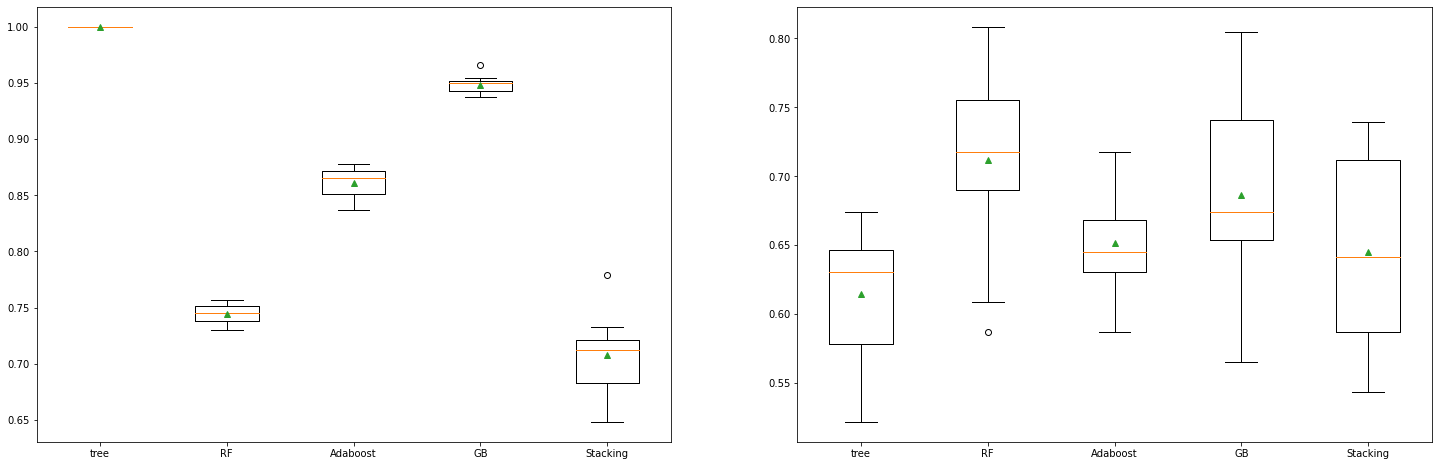

In [26]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import make_scorer

models = get_models()
kf = KFold(n_splits= 10,shuffle=True)
data_train = pd.DataFrame()
data_test = pd.DataFrame()

j = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    ### model
    #tree = DecisionTreeClassifier(min_samples_split= 30,
     #                             min_samples_leaf = 10)
    
    #bagging = BaggingClassifier(n_estimators=20,
    #                           base_estimator=tree,
     #                          random_state=0)
    
    #RF = RandomForestClassifier(max_depth=5,
     #                      random_state=0)
    for name, model in models.items():
        modelfit = model.fit(X_train, y_train)
        predxclass_train= modelfit.predict(X_train)
        predxclass_test = modelfit.predict(X_test)
        
        #predxclass_train = np.argmax(pY_train, axis=1)
        #predxclass_test = np.argmax(pY_test, axis=1)
        
        data_test.loc[j,name] = metrics.accuracy_score(y_test,predxclass_test)
        data_train.loc[j,name] = metrics.accuracy_score(y_train,predxclass_train)
    j+=1
#data = [accuracy_train, accuracy_test, precision_train, precision_test, recall_train, recall_test, f1_train, f1_test, auc_train, auc_test]

plt.figure(figsize=(25,8))
ax = plt.subplot(121)
ax.boxplot(data_train,labels = list(data_train.columns),showmeans=True)
ax = plt.subplot(122)
ax.boxplot(data_test,labels = list(data_train.columns),showmeans=True)
plt.show()

In [27]:
models = get_models()

In [28]:
data_train

,tree,RF,Adaboost,GB,Stacking
0,1.0,0.730120,0.843373,0.951807,0.648193
1,1.0,0.737349,0.872289,0.944578,0.713253
2,1.0,0.740385,0.867788,0.949519,0.673077
3,1.0,0.752404,0.862981,0.937500,0.711538
4,1.0,0.747596,0.877404,0.942308,0.778846
5,1.0,0.735577,0.872596,0.937500,0.675481
6,1.0,0.742788,0.850962,0.949519,0.704327
7,1.0,0.757212,0.850962,0.966346,0.733173
8,1.0,0.752404,0.870192,0.954327,0.713942
9,1.0,0.750000,0.836538,0.949519,0.723558


In [29]:
model

StackingClassifier(cv=5,
                   estimators=[('bayes', GaussianNB()),
                               ('lda',
                                LinearDiscriminantAnalysis(n_components=1)),
                               ('qda', QuadraticDiscriminantAnalysis()),
                               ('knn', KNeighborsClassifier()),
                               ('Tree', DecisionTreeClassifier())],
                   final_estimator=DecisionTreeClassifier(random_state=0))

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
kf = KFold(n_splits= 5,shuffle=True)
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision','f1_score' : 'f1', 'recall' : 'recall'}
ss = cross_validate(model, X_train, y_train, scoring= scoring, cv=kf, n_jobs=-1, error_score='raise', return_train_score=True)

In [31]:
cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kf, n_jobs=-1, error_score='raise')

NameError: name 'cross_val_score' is not defined

In [32]:
pd.DataFrame(ss)

,fit_time,score_time,test_accuracy,train_accuracy,test_prec,train_prec,test_f1_score,train_f1_score,test_recall,train_recall
0,0.275552,0.023609,0.750000,0.698795,0.655172,0.565217,0.644068,0.565217,0.633333,0.565217
1,0.253511,0.023700,0.554217,0.726727,0.451613,0.586207,0.430769,0.599119,0.411765,0.612613
2,0.241368,0.029479,0.710843,0.723724,0.482759,0.625000,0.538462,0.619835,0.608696,0.614754
3,0.247680,0.025560,0.590361,0.696697,0.437500,0.562500,0.451613,0.555066,0.466667,0.547826
4,0.205520,0.017997,0.554217,0.732733,0.371429,0.632075,0.412698,0.600897,0.464286,0.572650


In [33]:
ss['test_prec']

array([0.65517241, 0.4516129 , 0.48275862, 0.4375    , 0.37142857])

In [118]:
param_grid = {'max_depth': [None,3, 5, 10],
              'min_samples_split': [2, 5, 10]}
mm = models['RF']

In [115]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV

In [128]:
base_estimator = RandomForestClassifier(random_state=0)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30,refit=True).fit(X_train, y_train)


In [159]:
from sklearn.model_selection import GridSearchCV
scoring = {'accuracy': make_scorer(accuracy_score),'prec': 'precision','f1_score' : 'f1', 'recall' : 'recall'}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 60, 1)},cv = 5,
                  scoring=scoring, refit='f1_score', return_train_score=True).fit(X_train, y_train)
results = gs.cv_results_

In [160]:
sum(sh.predict(X_test)!= y_test)/len(y_test)

0.3695652173913043

In [161]:
sum(gs.predict(X_test)!= y_test)/len(y_test)

0.43478260869565216

In [162]:
gs.best_estimator_

DecisionTreeClassifier(min_samples_split=42, random_state=42)

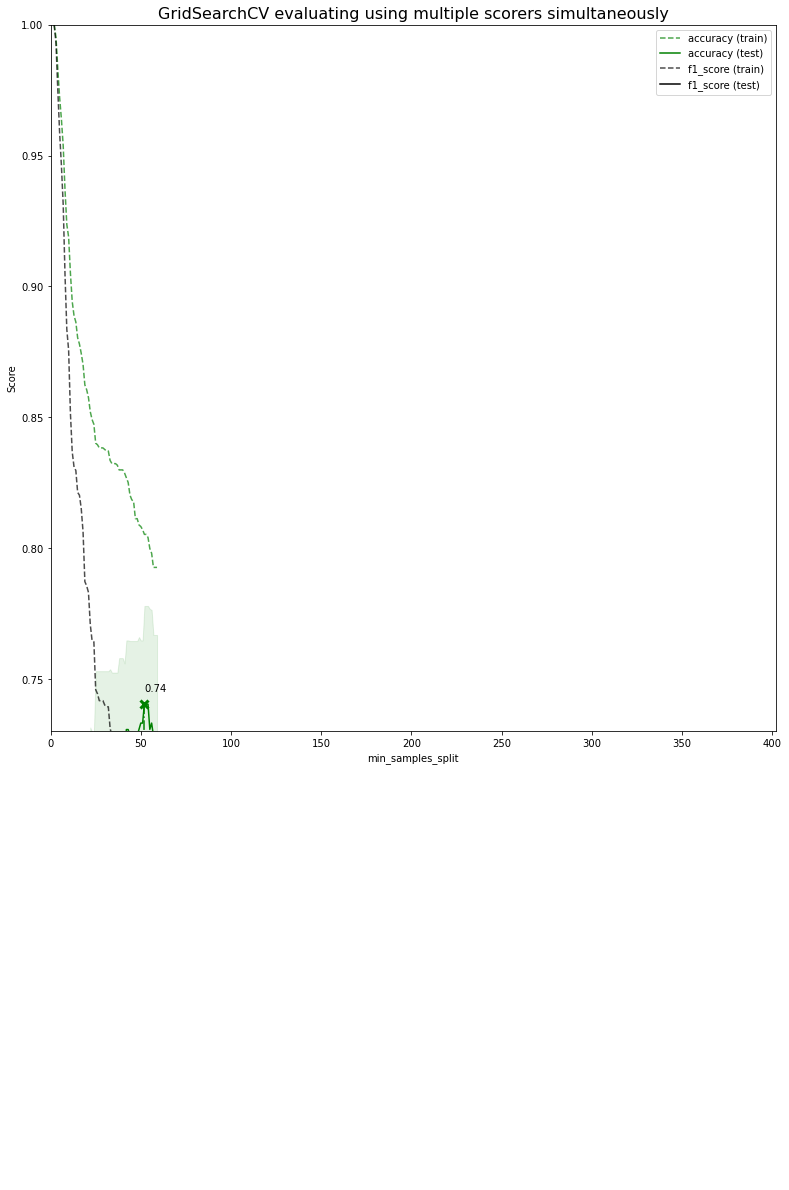

In [163]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [151]:
results

{'mean_fit_time': array([0.00507989, 0.00614524, 0.0051671 , 0.00549564, 0.00580544,
        0.00598617, 0.00606914, 0.00622931]),
 'std_fit_time': array([7.84306762e-04, 6.32095668e-04, 1.96380658e-04, 1.54645179e-04,
        1.20879245e-04, 1.22580487e-04, 1.13052187e-04, 7.61099325e-05]),
 'mean_score_time': array([0.01621838, 0.01805577, 0.01337605, 0.01282272, 0.01245236,
        0.01239181, 0.01285696, 0.01256733]),
 'std_score_time': array([3.39741044e-03, 2.70488680e-03, 7.93828118e-04, 3.87044835e-04,
        1.20253945e-04, 8.71844293e-05, 4.52075602e-04, 1.74907510e-04]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9}],
 'split0_test_accuracy': array([0.72619048, 0.